/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0374
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0137
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0103
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100
Epoch 13/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097
Epoch 14/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100
Epoch 15/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - l

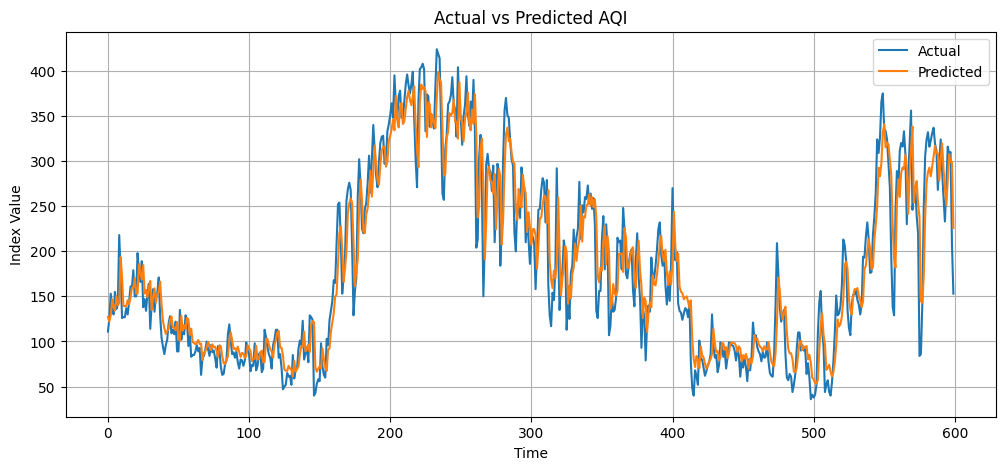

In [ ]:
# =============================
#   IMPORT LIBRARIES
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =============================
#   LOAD DATA
# =============================
df = pd.read_csv('/content/Patna_AQIBulletins.csv')   # change path if needed
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# =============================
#   TRAIN TEST SPLIT
# =============================
train_df = df[df['date'] < '2022-05-01']
test_df  = df[df['date'] >= '2022-05-01']

train = train_df[['Index Value']]
test  = test_df[['Index Value']]

# =============================
#   SCALING
# =============================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)

# =============================
#   SEQUENCE CREATION
# =============================
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 10
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test   = create_sequences(test_scaled, lookback)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], lookback, 1)
X_test  = X_test.reshape(X_test.shape[0], lookback, 1)

# =============================
#   LSTM MODEL
# =============================
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# =============================
#   TRAINING
# =============================
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# =============================
#   PREDICTION
# =============================
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test)

# =============================
#   METRICS
# =============================
r2 = r2_score(y_true, pred)
mae = mean_absolute_error(y_true, pred)
mse = mean_squared_error(y_true, pred)
rmse = np.sqrt(mse)

print("\n----- MODEL PERFORMANCE -----")
print("R2 Score  :", r2)
print("MAE       :", mae)
print("MSE       :", mse)
print("RMSE      :", rmse)

# =============================
#   PLOT RESULTS
# =============================
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(pred, label="Predicted")
plt.title("Actual vs Predicted AQI")
plt.xlabel("Time")
plt.ylabel("Index Value")
plt.legend()
plt.grid()
plt.show()
